In [22]:
# HRNet Training in Notebook (Using DataParallel for Multi-GPU)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import json
import datetime
import time
import numpy as np
import torch
from torch.utils import data
import matplotlib.pyplot as plt
import cv2

from model import HighResolutionNet
from my_dataset_coco import CocoKeypoint
import transforms
from train_utils import train_eval_utils as utils
from pycocotools.coco import COCO
# ========== Config ==========
class Args:
    data_path = './data/bsf2023'
    keypoints_path = './bsf_keypoints.json'
    person_det = None
    fixed_size = [256, 192]
    num_joints = 2
    batch_size = 32
    start_epoch = 0
    epochs = 20
    workers = 4
    lr = 0.0003
    weight_decay = 1e-4
    lr_steps = [12, 18]
    lr_gamma = 0.1
    print_freq = 50
    output_dir = './multi_train'
    resume = ''
    amp = False
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    sync_bn = False

args = Args()
os.makedirs(args.output_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# ========== Prepare Data ==========
with open(args.keypoints_path, "r") as f:
    person_kps_info = json.load(f)

heatmap_hw = (args.fixed_size[0] // 4, args.fixed_size[1] // 4)
kps_weights = np.array(person_kps_info["kps_weights"], dtype=np.float32).reshape((args.num_joints,))
data_transform = {
    "train": transforms.Compose([
        # transforms.HalfBody(0.3, person_kps_info["upper_body_ids"], person_kps_info["lower_body_ids"]),
        transforms.AffineTransform(scale=(0.65, 1.35), rotation=(-45, 45), fixed_size=args.fixed_size),
        transforms.RandomHorizontalFlip(0.5, person_kps_info["flip_pairs"]),
        transforms.KeypointToHeatMap(heatmap_hw=heatmap_hw, gaussian_sigma=2, keypoints_weights=kps_weights),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
     "val": transforms.Compose([
        transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=args.fixed_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
print("Loading training data...")
# train_dataset = CocoKeypoint(args.data_path, "train", transforms=data_transform["train"], fixed_size=args.fixed_size)
train_dataset = CocoKeypoint(args.data_path, "train", years="2.0", transforms=data_transform["train"], fixed_size=args.fixed_size)
train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, collate_fn=train_dataset.collate_fn)

print("Loading validation data...")
# val_dataset = CocoKeypoint(args.data_path, "val", transforms=data_transform["val"], fixed_size=args.fixed_size)
val_dataset = CocoKeypoint(args.data_path, "val", years="2.0", transforms=data_transform["val"], fixed_size=args.fixed_size)

val_loader = data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, collate_fn=val_dataset.collate_fn)

print("Checking training images for corrupt files...")
train_coco = COCO(os.path.join(args.data_path, 'annotations/coco_train.json'))
train_img_dir = os.path.join(args.data_path, 'train')
valid_ids = []

for img_info in train_coco.loadImgs(train_coco.getImgIds()):
    img_path = os.path.join(train_img_dir, img_info['file_name'])
    img = cv2.imread(img_path)
    if img is not None:
        valid_ids.append(img_info['id'])
    else:
        print(f"[WARNING] Skipping corrupt image: {img_path}")

# 仅保留非损坏图像和其注释
train_coco.dataset['images'] = [img for img in train_coco.dataset['images'] if img['id'] in valid_ids]
train_coco.dataset['annotations'] = [ann for ann in train_coco.dataset['annotations'] if ann['image_id'] in valid_ids]
train_coco.createIndex()

# 替换 CocoKeypoint 的 __getitem__ 方法以容错
from types import MethodType

def safe_getitem(self, idx):
    try:
        return self._original_getitem(idx)
    except Exception as e:
        print(f"[ERROR] Skipping index {idx} due to error: {e}")
        return self.__getitem__((idx + 1) % len(self))  # 简单跳过当前损坏项

train_dataset = CocoKeypoint(args.data_path, "train", transforms=data_transform["train"], fixed_size=args.fixed_size)
train_dataset.coco = train_coco
train_dataset._original_getitem = train_dataset.__getitem__
train_dataset.__getitem__ = MethodType(safe_getitem, train_dataset)

train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, collate_fn=train_dataset.collate_fn)

Loading training data...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading validation data...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Checking training images for corrupt files...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [24]:
# ========== Create Model ==========
def create_model(num_joints):
    model = HighResolutionNet(base_channel=32, num_joints=num_joints)
    weights_dict = torch.load("./hrnet_trained.pth", map_location='cpu')
    for k in list(weights_dict.keys()):
        if ("head" in k) or ("fc" in k):
            del weights_dict[k]
        if "final_layer" in k and weights_dict[k].shape[0] != num_joints:
            del weights_dict[k]
    model.load_state_dict(weights_dict, strict=False)
    return model
model = create_model(args.num_joints).to(args.device)
print("Model loaded successfully. Device:", next(model.parameters()).device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs via DataParallel")
    model = torch.nn.DataParallel(model)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=args.lr, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.lr_steps, gamma=args.lr_gamma)
scaler = torch.cuda.amp.GradScaler() if args.amp else None
print("Model created successfully")
# print(model)


Model loaded successfully. Device: cuda:0
Using 2 GPUs via DataParallel
Model created successfully


In [25]:
# ========== Train ==========
# train_loss, learning_rate = [], []
# print("Start training...")
# for epoch in range(args.start_epoch, args.epochs):
#     mean_loss, lr = utils.train_one_epoch(model, optimizer, train_loader, device=args.device, epoch=epoch, print_freq=args.print_freq, warmup=True, scaler=scaler)
#     lr_scheduler.step()

#     train_loss.append(mean_loss.item())
#     learning_rate.append(lr)
#     # ==== Evaluate on validation set ====
#     coco_info = utils.evaluate(model, val_loader, device=args.device, flip=True, flip_pairs=person_kps_info["flip_pairs"])
#     val_map.append(coco_info[1])

#     print(f"Epoch {epoch}: loss={mean_loss.item():.4f}, lr={lr:.6f}, mAP@0.5={coco_info[1]:.4f}")
#     torch.save(model.state_dict(), os.path.join(args.output_dir, f"model_epoch_{epoch}.pth"))


    # print(f"Epoch {epoch}: loss={mean_loss.item():.4f}, lr={lr:.6f}")

    # torch.save(model.state_dict(), os.path.join(args.output_dir, f"model_epoch_{epoch}.pth"))
import time

train_loss, learning_rate, val_map = [], [], []
best_map = 0.0  # 🔥 记录当前最优mAP
best_epoch = -1
print("Start training...")
print("{:^6} | {:^10} | {:^12} | {:^12} | {:^20}".format("Epoch", "LR", "Train Loss", "Val mAP@0.5", "Time"))
print("-" * 68)

for epoch in range(args.start_epoch, args.epochs):  # ✏️ 设置为 20 个 epoch
    start_time = time.time()

    # === 训练 ===
    mean_loss, lr = utils.train_one_epoch(
        model, optimizer, train_loader,
        device=args.device, epoch=epoch,
        print_freq=args.print_freq, warmup=True, scaler=scaler
    )
    lr_scheduler.step()
    
    # 保存 loss 和 lr
    train_loss.append(mean_loss.item())
    learning_rate.append(lr)

    # === 验证 ===
    coco_info = utils.evaluate(
        model, val_loader,
        device=args.device,
        flip=True,
        flip_pairs=person_kps_info["flip_pairs"]
    )
    map_score = coco_info[0]
    val_map.append(map_score)

    # === 打印结果 ===
    elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print("{:^6} | {:^10.6f} | {:^12.4f} | {:^12.4f} | {:^20}".format(
        epoch, lr, mean_loss.item(), map_score, elapsed
    ))

    # === Save the current epoch model ===
    torch.save(
        model.state_dict(),
        os.path.join(args.output_dir, f"model20_1218_epoch_{epoch}.pth")
    )

    # === Determine whether it is currently the best ===
    if map_score > best_map:
        best_map = map_score
        best_epoch = epoch
        torch.save(
            model.state_dict(),
            os.path.join(args.output_dir, "best_model20_1218.pth")
        )
        print(f"✅ Best model updated at epoch {epoch}, mAP@0.5 = {best_map:.4f}")

print("-" * 68)
print(f"Training Finished 🎯  Best Epoch: {best_epoch}, Best mAP@0.5: {best_map:.4f}")

Start training...
Epoch  |     LR     |  Train Loss  | Val mAP@0.5  |         Time        
--------------------------------------------------------------------
Epoch: [0]  [ 0/39]  eta: 0:05:34  lr: 0.000008  loss: 0.0519 (0.0519)  time: 8.5719  data: 8.0977  max mem: 2828
Epoch: [0]  [38/39]  eta: 0:00:01  lr: 0.000300  loss: 0.0321 (0.0440)  time: 1.8808  data: 1.4157  max mem: 2828
Epoch: [0] Total time: 0:01:16 (1.9729 s / it)
Test:   [0/5]  eta: 0:00:41  model_time: 0.2866 (0.2866)  time: 8.3289  data: 7.8968  max mem: 2828
Test:   [4/5]  eta: 0:00:02  model_time: 0.2103 (0.2432)  time: 2.1611  data: 1.7912  max mem: 2828
Test:  Total time: 0:00:10 (2.1951 s / it)
Averaged stats: model_time: 0.2103 (0.2432)
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: keypoints
 Average Precision  (AP) @[ IoU=0.50:0.

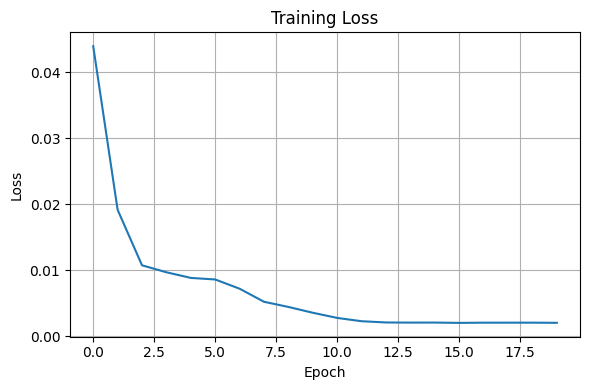

In [26]:
# ========== Visualization ==========
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()